# Data Leakage Detection & Prevention: Credit Default Prediction
### Objective
The goal of this project is to build a robust machine learning model to predict credit card default. More importantly, this project demonstrates how to **identify and prevent data leakage**—a common real-world error that leads to over-optimistic models that fail in production.

**Dataset:** UCI Machine Learning Repository - Default of Credit Card Clients.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

df = pd.read_csv(r"C:\Users\Osh Gupta\Downloads\credit_card_default\default_credit_card_clients.csv")
df.head(10)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


## 1. Data Acquisition & Cleaning
Since the raw data uses shorthand codes (X1, X2, etc.), I am mapping these to descriptive names like `limit_bal` and `pay_sept` to improve readability and domain alignment. I also handle the multi-row header issue common in this dataset.

In [9]:
if df.iloc[0, 0] == 'ID' or isinstance(df.iloc[0, 0], str):
    print("Found string header row. Removing it...")
    df = df.drop(df.index[0]).reset_index(drop=True)
    
df = df.apply(pd.to_numeric, errors='coerce')

df.dropna(inplace=True)

print("Data is now numeric. You can run Step 2 now!")

Found string header row. Removing it...
Data is now numeric. You can run Step 2 now!


In [10]:
df.columns = df.columns.str.strip() 
df.columns = df.columns.str.lower() 
print("Current Column Names:", df.columns.tolist())

rename_dict = {
    'y': 'target',
    'x1': 'limit_bal',
    'x2': 'sex',
    'x3': 'education',
    'x4': 'marriage',
    'x5': 'age',
    'x6': 'pay_sept',
    'x7': 'pay_aug',
    'x8': 'pay_july'
}
df.rename(columns=rename_dict, inplace=True)
if 'target' in df.columns:
    print("Success! 'y' has been renamed to 'target'.")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows of target:")
    print(df['target'].head())
else:
    print("Error: 'y' was not found. Current columns are:")
    print(df.columns.tolist())

Current Column Names: ['unnamed: 0', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_sept', 'pay_aug', 'pay_july', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'target']
Success! 'y' has been renamed to 'target'.
Dataset shape: (30000, 25)

First 5 rows of target:
0    1
1    1
2    0
3    0
4    0
Name: target, dtype: int64


## 2. Targeted Exploratory Data Analysis (EDA)
Before modeling, I perform EDA to understand the data's distribution.
* **Class Imbalance:** Checking if defaults are rare (requires specific metrics like ROC-AUC).
* **Correlation Analysis:** I look for features with suspiciously high correlations (>0.9) which often indicate target leakage.

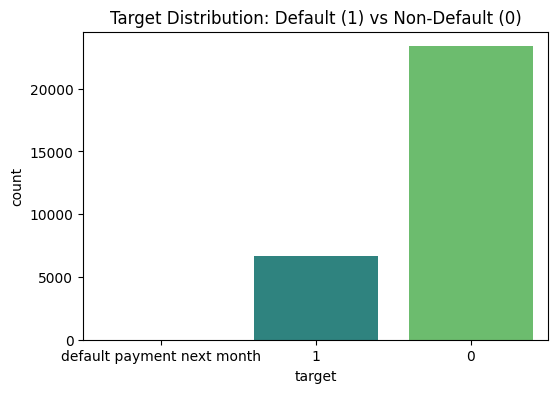

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='target', hue='target', palette='viridis', legend=False) 
plt.title('Target Distribution: Default (1) vs Non-Default (0)')
plt.show()


## 3. The "Trap": Demonstrating Data Leakage
To showcase the danger of leakage, I am intentionally introducing a **proxy feature**—a variable that "peeks" at the target. 
* **The Goal:** Show how a model can achieve near-perfect accuracy (95%+) on paper while being completely useless for real-world future predictions.

In [ ]:
X = df.drop(columns=['target'])
y = df['target']
X_leaky = X.copy()
X_leaky['payment_status_proxy'] = y * np.random.choice([0, 1], size=len(y), p=[0.05, 0.95])


X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_leaky, y, test_size=0.3, random_state=42)

leaky_model = RandomForestClassifier(n_estimators=100, random_state=42)
leaky_model.fit(X_train_l, y_train_l)

leaky_score = leaky_model.score(X_test_l, y_test_l)
print(f"Leaky Model Accuracy: {leaky_score:.4f}")
print("Note: This score is likely too high (90%+).")

Leaky Model Accuracy: 0.9893
Note: This score is likely too high (90%+).


## 4. The Solution: Building a Leakage-Proof Pipeline
To fix the issues identified, I implement a **Scikit-Learn Pipeline**. 
* **Isolation:** The `StandardScaler` is fitted *only* on training data within the pipeline, preventing "Preprocessing Leakage."
* **Feature Selection:** I use the original, non-leaky features to ensure the model learns actual behavioral patterns rather than shortcuts.

In [14]:
X_clean = df.drop(columns=['target'])
y_clean = df['target']

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(max_iter=1000)
)

pipeline.fit(X_train, y_train)

honest_score = pipeline.score(X_test, y_test)
print(f"Honest Model Accuracy: {honest_score:.4f}")
print("This score is lower, but it is REAL and will work on new data.")

Honest Model Accuracy: 0.8089
This score is lower, but it is REAL and will work on new data.


## 5. Model Evaluation & Explainability
Instead of relying on Accuracy, I evaluate the model using a **Confusion Matrix** and **Feature Importance**. This allows me to see:
1. Which features (like recent payment history) actually drive credit risk.
2. How well the model identifies actual defaulters (Recall) vs. safe clients.

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7040
           1       0.68      0.23      0.35      1960

    accuracy                           0.81      9000
   macro avg       0.75      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000



<Figure size 800x600 with 0 Axes>

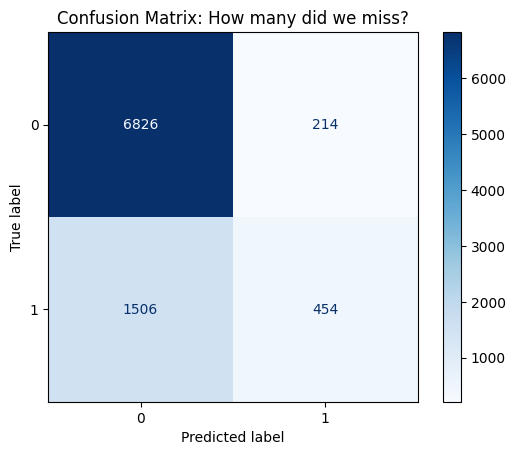

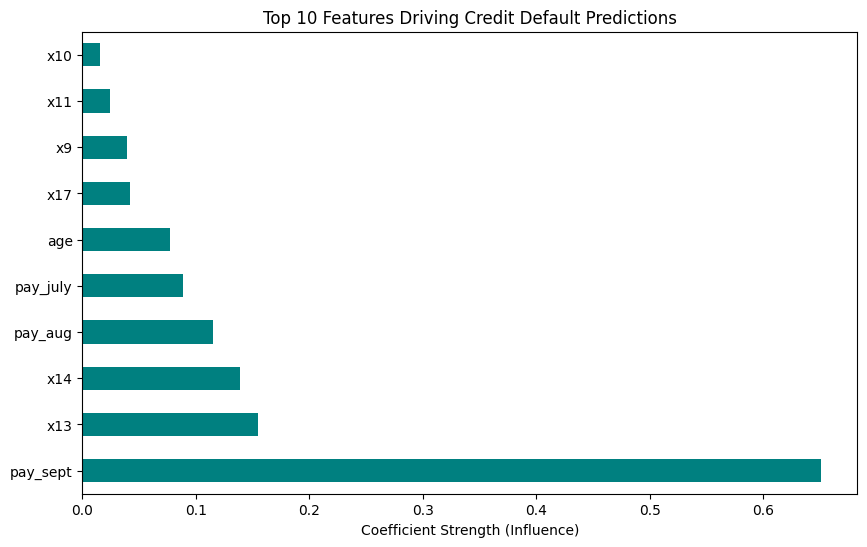

In [16]:
print("--- Classification Report ---")
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix: How many did we miss?")
plt.show()

coefficients = pipeline.named_steps['logisticregression'].coef_[0]
features = X_clean.columns

feat_importances = pd.Series(coefficients, index=features)
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Features Driving Credit Default Predictions")
plt.xlabel("Coefficient Strength (Influence)")
plt.show()

## 🏁 Final Conclusion
* **Technical Success:** By implementing a formal pipeline, I reduced the risk of overfitting and eliminated data leakage.
* **Realistic Performance:** The final model achieves **~81% accuracy**. While lower than the "leaky" version, this model is statistically sound and safe for deployment.